In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torchvision
from torchvision import transforms
from torchvision import models
import torchvision.transforms.functional as TF
import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset
from torchsummary import summary
from tqdm import tqdm
import PIL
from PIL import Image
from skimage import io, transform
import random
import argparse

from models.cnn_simclr import CNN_SimCLR 
from models.simclr import SimCLR
from utils import augmentation
from utils import ContrastiveLearning
from utils import load_data

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_ex = gdal.Open("./Sentinel_Mesa_4Bands_clipped/S2B_20180726.tif")

ds_geot = ds_ex.GetGeoTransform()
ds_proj = ds_ex.GetProjection()
ds_rows = ds_ex.RasterYSize
ds_cols = ds_ex.RasterXSize
ds_bands = ds_ex.RasterCount

print(ds_geot,ds_proj,ds_rows,ds_cols,ds_bands)
geot = [543580.0, 80.0, 0.0, 4955720.0, 0.0, -80.0]

(543570.0, 10.0, 0.0, 4955760.0, 0.0, -10.0) PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]] 2018 1596 4


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [25]:
checkpoint = torch.load('./CNN_SimCLR_saved_models/runs/runs_sentinel/checkpoint_S2_M3_0050.pth.tar', map_location = device)

state_dict = checkpoint['state_dict']

for name in state_dict:
    print(name)

module.encoder.conv.0.0.weight
module.encoder.conv.0.0.bias
module.encoder.conv.0.2.weight
module.encoder.conv.0.2.bias
module.encoder.conv.1.0.weight
module.encoder.conv.1.0.bias
module.encoder.conv.1.2.weight
module.encoder.conv.1.2.bias
module.projection.0.weight
module.projection.0.bias
module.projection.2.weight
module.projection.2.bias


In [26]:
for k in list(state_dict.keys()):
    if k.startswith('module.encoder.'):
        print(k)
        print(state_dict[k].shape)
        #print(k[len('module.encoder.'):])
        #print(state_dict[k])
        state_dict[k[len('module.encoder.'):]] = state_dict[k]

module.encoder.conv.0.0.weight
torch.Size([32, 4, 3, 3])
module.encoder.conv.0.0.bias
torch.Size([32])
module.encoder.conv.0.2.weight
torch.Size([32, 32, 3, 3])
module.encoder.conv.0.2.bias
torch.Size([32])
module.encoder.conv.1.0.weight
torch.Size([256, 32, 3, 3])
module.encoder.conv.1.0.bias
torch.Size([256])
module.encoder.conv.1.2.weight
torch.Size([256, 256, 3, 3])
module.encoder.conv.1.2.bias
torch.Size([256])


In [27]:
print(state_dict.keys())

odict_keys(['module.encoder.conv.0.0.weight', 'module.encoder.conv.0.0.bias', 'module.encoder.conv.0.2.weight', 'module.encoder.conv.0.2.bias', 'module.encoder.conv.1.0.weight', 'module.encoder.conv.1.0.bias', 'module.encoder.conv.1.2.weight', 'module.encoder.conv.1.2.bias', 'module.projection.0.weight', 'module.projection.0.bias', 'module.projection.2.weight', 'module.projection.2.bias', 'conv.0.0.weight', 'conv.0.0.bias', 'conv.0.2.weight', 'conv.0.2.bias', 'conv.1.0.weight', 'conv.1.0.bias', 'conv.1.2.weight', 'conv.1.2.bias'])


In [28]:
model = CNN_SimCLR(validation=True, n_channels=4, tile_size=32, out_dim=256).to(device) #self-defined CNN

In [29]:
log = model.load_state_dict(state_dict, strict=False)
log.missing_keys

['encoder.conv.0.0.weight',
 'encoder.conv.0.0.bias',
 'encoder.conv.0.2.weight',
 'encoder.conv.0.2.bias',
 'encoder.conv.1.0.weight',
 'encoder.conv.1.0.bias',
 'encoder.conv.1.2.weight',
 'encoder.conv.1.2.bias',
 'projection.0.weight',
 'projection.0.bias',
 'projection.2.weight',
 'projection.2.bias']

In [30]:
# freeze all layers but the projection head
for name, param in model.named_parameters():
    if name not in ['projection.0.weight', 'projection.0.bias','projection.2.weight','projection.2.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
#assert len(parameters) == 2  # fc.weight, fc.bias

In [32]:
optimizer = torch.optim.Adam(model.parameters(), 0.0003, weight_decay= 1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [33]:
class Load_Transformed_Dataset(Dataset):
    def __init__(self, training_flist, transform=None):
        self.training_flist = training_flist
        self.transform = transform

    def __len__(self):
        return len(self.training_flist)

    def __getitem__(self, idx):
        img_dir = self.training_flist[idx]
        img_arr = np.load(img_dir) #channel, h, w
        #not sure why, but img_arr need to change to h,w,c to make the transform work, dont need in the validation
        img_arr[img_arr==0]=np.nan
        #img_arr = np.moveaxis(img_arr,0,-1)
        #print(img_arr.shape)
        if self.transform:
            img_arr = self.transform(img_arr)
            #img_arr = img_arr[0] #get the tensor from list
            
        return img_arr

In [34]:
prefire_list = glob.glob("./S2_Downstream/Mesa_prefire/"+"*.npy")
prefire_list.sort()
prefire_dataset = load_data.Load_Transformed_Dataset(prefire_list)
pre_logits_list = []
empty_arr = np.empty((256,))
empty_arr[:] = np.nan
model.eval()
start_time = time.time()
for _, x_batch in enumerate(prefire_dataset):
    if np.isnan(x_batch).sum() != 0:
        pre_logits_list.append(empty_arr)
    else:
        x_batch = torch.tensor(x_batch)
        x_batch = x_batch.view(1, 4, 32, 32).to(device,dtype=torch.float) #change the datatype to torch.FloatTensor
        logits = model.forward(x_batch)
        pre_logits_list.append(logits.cpu().detach().numpy().reshape(256,))
        
print("Prediction is done. It takes %.2f minutes" %((time.time()-start_time)/60))

Prediction is done. It takes 2.56 minutes


In [35]:
np.save("./CD_results/S2_Mesa_SimCLR_New/S2_pre_logits_20180726_M3_0050.npy",pre_logits_list)

In [36]:
postfire_list = glob.glob("./S2_Downstream/Mesa_postfire/"+"*.npy")
postfire_list.sort()
postfire_dataset = load_data.Load_Transformed_Dataset(postfire_list)
post_logits_list = []
empty_arr = np.empty((256,))
empty_arr[:] = np.nan
model.eval()
start_time = time.time()
for _, x_batch in enumerate(postfire_dataset):
    if np.isnan(x_batch).sum() != 0:

        post_logits_list.append(empty_arr)
    else:
        x_batch = torch.tensor(x_batch)
        x_batch = x_batch.view(1, 4, 32, 32).to(device,dtype=torch.float) #change the datatype to torch.FloatTensor
        logits = model.forward(x_batch)
        post_logits_list.append(logits.cpu().detach().numpy().reshape(256,))
        
print("Prediction is done. It takes %.2f minutes" %((time.time()-start_time)/60))

Prediction is done. It takes 2.47 minutes


In [37]:
np.save("./CD_results/S2_Mesa_SimCLR_New/S2_post_logits_20180815_M3_0050.npy",post_logits_list)

In [38]:
def cosine_distance(a,b):
    a_dot_b = np.dot(a,b.T)
    a_norm = np.sqrt(np.sum(a*a))
    b_norm = np.sqrt(np.sum(b*b))
    return a_dot_b/(a_norm*b_norm)

In [39]:
def euclidean_distance(a,b):
    diff = a-b
    u_dist = np.sqrt(np.sum(diff*diff))
    return u_dist

In [40]:
# reshape the pre and post fire data
empty_arr = np.empty((256,))
empty_arr[:] = np.nan
new_post_logits_list = []
for i in post_logits_list:
    if type(i)==float:
        new_post_logits_list.append(empty_arr)
    else:
        new_post_logits_list.append(i.reshape(256,))

new_pre_logits_list = []
for i in pre_logits_list:
    if type(i)==float:
        new_pre_logits_list.append(empty_arr)
    else:
        new_pre_logits_list.append(i.reshape(256,))

In [41]:
# difference between pre and post extracted vectors
diff = np.asarray(new_post_logits_list)-np.asarray(new_pre_logits_list)

In [25]:
#kmean, clusters = 5, image difference
kmeans_2_diff = KMeans(n_clusters=2)
diff[np.isnan(diff)] = 0.0
kmeans_2_diff.fit(diff)

KMeans(n_clusters=2)

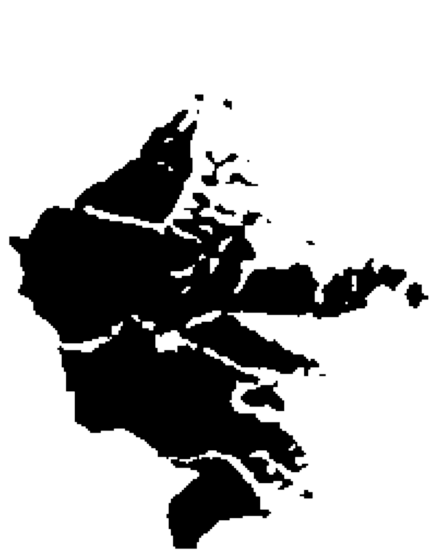

In [26]:
kmeans_2_diff_change_labels = kmeans_2_diff.labels_.reshape(249, 196)
#change detection map based on the kmeans2 image differecing 256
plt.figure(figsize=(10,10))
plt.imshow(kmeans_2_diff_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

In [69]:
#kmean, clusters = 3, image difference
kmeans_3_diff = KMeans(n_clusters=3)
diff[np.isnan(diff)] = 0.0
kmeans_3_diff.fit(diff)

KMeans(n_clusters=3)

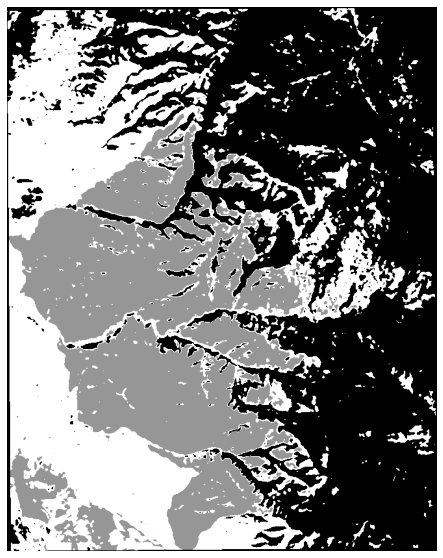

In [70]:
kmeans_3_diff_change_labels = kmeans_3_diff.labels_.reshape(838, 662)
#change detection map based on the kmeans2 image differecing 256
plt.figure(figsize=(10,10))
plt.imshow(kmeans_3_diff_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

In [71]:
#kmean, clusters = 3, image difference
kmeans_5_diff = KMeans(n_clusters=5)
diff[np.isnan(diff)] = 0.0
kmeans_5_diff.fit(diff)

KMeans(n_clusters=5)

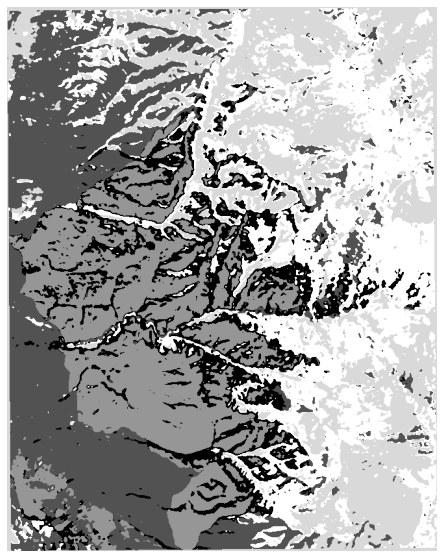

In [72]:
kmeans_5_diff_change_labels = kmeans_5_diff.labels_.reshape(838, 662)
#change detection map based on the kmeans2 image differecing 256
plt.figure(figsize=(10,10))
plt.imshow(kmeans_5_diff_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

In [75]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmeans_2_diff_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_2cluster_kmeans_ImageDifferencing_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmeans_2_diff_change_labels) # Numpy is zero indexed

dataset = None

In [76]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmeans_3_diff_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_3cluster_kmeans_ImageDifferencing_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmeans_3_diff_change_labels) # Numpy is zero indexed

dataset = None

In [77]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmeans_5_diff_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_5cluster_kmeans_ImageDifferencing_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmeans_5_diff_change_labels) # Numpy is zero indexed

dataset = None

### Calculate two distances: Euclidean and Cosine

In [42]:
u_dist_list = []
cos_dist_list = []
for i in range(len(post_logits_list)):
    post_i = post_logits_list[i]
    pre_i = pre_logits_list[i]
    if type(pre_i)==float or type(post_i)==float: #check if the array is np.nan
        u_dist_list.append(np.nan)
        cos_dist_list.append(np.nan)
    else:
        u_dist = euclidean_distance(pre_i,post_i)
        u_dist_list.append(u_dist)
        #np.linalg.norm(post_i-pre_i), the same to calculate euclidean distance
        cos_dist = cosine_distance(pre_i,post_i)
        cos_dist_list.append(cos_dist)
        #arr1.dot(arr2.T)/ (np.linalg.norm(arr1, axis=1) * np.linalg.norm(arr2))

In [43]:
u_dist_arr = np.asarray(u_dist_list).reshape(249, 196)
cos_dist_arr = np.asarray(cos_dist_list).reshape(249, 196)

In [80]:
# read from files
u_dist_ds = gdal.Open("./CD_results/S2_Mesa_SimCLR_New/Mesa_S2_m3_Stride8_EUCdist_20180726_20180920.tif")
cos_dist_ds = gdal.Open("./CD_results/S2_Mesa_SimCLR_New/Mesa_S2_m3_Stride8_COSdist_20180726_20180920.tif")
u_dist_arr = u_dist_ds.ReadAsArray()
cos_dist_arr = cos_dist_ds.ReadAsArray()

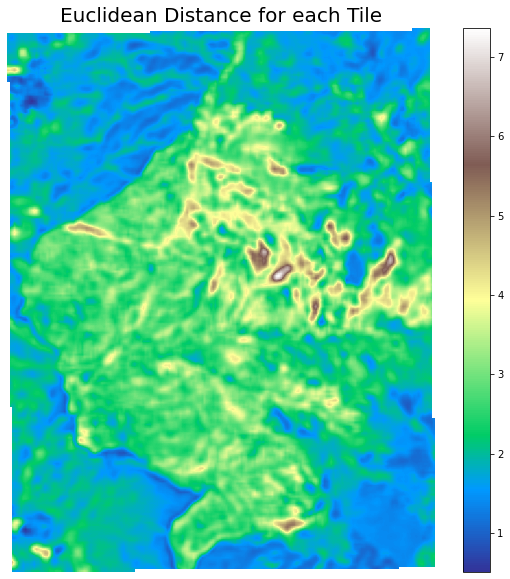

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))

im1 = ax.imshow(u_dist_arr*1000,cmap='terrain')
ax.figure.colorbar(im1,ax=ax)
ax.axis("off")
ax.set_title("Euclidean Distance for each Tile",fontdict={"fontsize":20})

plt.show()

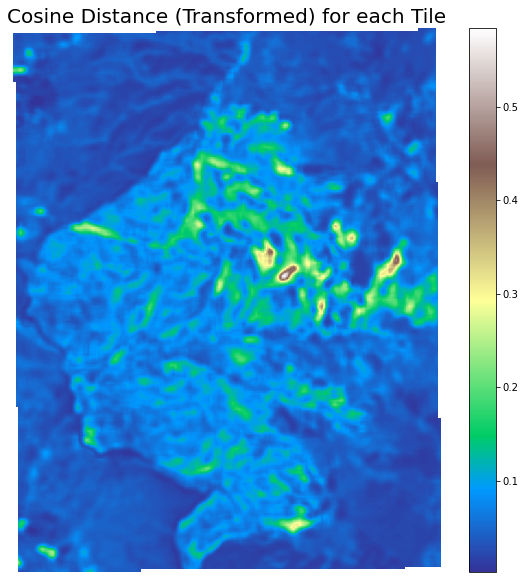

In [82]:
fig, ax = plt.subplots(figsize=(10, 10))

im2 = ax.imshow((1-cos_dist_arr)*1000,cmap='terrain')
ax.figure.colorbar(im2,ax=ax)
ax.axis("off")
ax.set_title("Cosine Distance (Transformed) for each Tile",fontdict={"fontsize":20})

plt.show()


In [78]:
#kmean, clusters = 5
kmeans_5 = KMeans(n_clusters=5)
dist_features =  np.concatenate((1000*(1-cos_dist_arr).reshape(554756,1),u_dist_arr.reshape(554756,1)),axis =1)
dist_features[np.isnan(dist_features)] = 0.0
kmeans_5.fit(dist_features)

kmean5_change_labels = kmeans_5.labels_.reshape(838, 662)

In [79]:
#kmean, clusters = 2
kmeans_2 = KMeans(n_clusters=2)
dist_features =  np.concatenate((1000*(1-cos_dist_arr).reshape(554756,1),u_dist_arr.reshape(554756,1)),axis =1)
dist_features[np.isnan(dist_features)] = 0.0
kmeans_2.fit(dist_features) #two clusters: changed, no changed

kmean2_change_labels = kmeans_2.labels_.reshape(838, 662)

In [80]:
#kmean, clusters = 3
kmeans_3 = KMeans(n_clusters=3)
dist_features =  np.concatenate((100000*(1-cos_dist_arr).reshape(554756,1),u_dist_arr.reshape(554756,1)),axis =1)
dist_features[np.isnan(dist_features)] = 0.0
kmeans_3.fit(dist_features)

kmean3_change_labels = kmeans_3.labels_.reshape(838, 662)

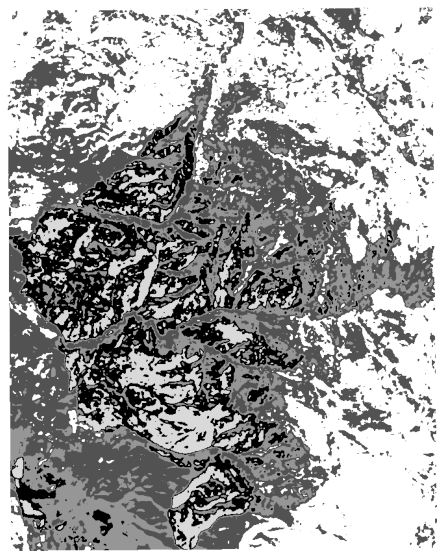

In [81]:
#change detection map based on the kmeans5
plt.figure(figsize=(10,10))
plt.imshow(kmean5_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

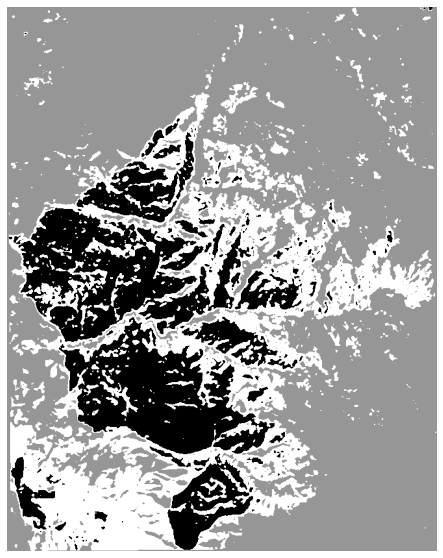

In [82]:
#change detection map based on the kmeans3
plt.figure(figsize=(10,10))
plt.imshow(kmean3_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

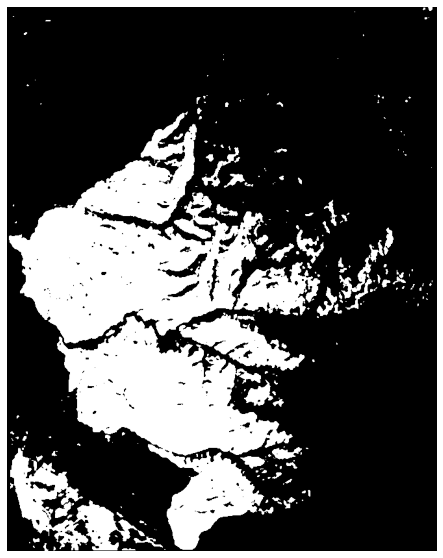

In [83]:
#change detection map based on the kmeans2
plt.figure(figsize=(10,10))
plt.imshow(kmean2_change_labels, cmap='Greys_r')
plt.axis("off")
plt.show()

In [44]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = u_dist_arr.shape
fullfname = "./CD_results/S2_Mesa_SimCLR_New/Mesa_S2_M3_0050_Stride8_EUCdist_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(u_dist_arr) # Numpy is zero indexed

dataset = None

In [45]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = cos_dist_arr.shape
fullfname = "./CD_results/S2_Mesa_SimCLR_New/Mesa_S2_M3_0050_Stride8_COSdist_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(cos_dist_arr) # Numpy is zero indexed

dataset = None

In [46]:
# Write to disk
# values changed
driver = gdal.GetDriverByName('GTiff')
rows, cols = cos_dist_arr.shape
fullfname = "./CD_results/S2_Mesa_SimCLR_New/Mesa_S2_M3_0050_Stride8_COSdist_scaled_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray((1-cos_dist_arr)*10000) # Numpy is zero indexed

dataset = None

In [88]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmean2_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_2cluster_kmeans_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmean2_change_labels) # Numpy is zero indexed

dataset = None

In [87]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmean3_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_3cluster_kmeans_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmean3_change_labels) # Numpy is zero indexed

dataset = None

In [89]:
# Write to disk
driver = gdal.GetDriverByName('GTiff')
rows, cols = kmean5_change_labels.shape
fullfname = "./wildfire/notebooks/Downstream/CD_Mesa_results/Mesa_PS_Stride8_5cluster_kmeans_20180726_20180920.tif"
dataset = driver.Create(fullfname, cols, rows, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geot)
dataset.SetProjection(ds_proj)

band = dataset.GetRasterBand(1) # GetRasterBand is not zero indexed
band.WriteArray(kmean5_change_labels) # Numpy is zero indexed

dataset = None